Simple TensorFlow image classification model based on [this tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [13]:
# if you have to install tensorflow, idk if opencv-python is needed
# ! pip install tensorflow opencv-python

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
# tf automatically labels the data based on the folder name
# and splits them into batches

batch_size = 32
img_height = 180
img_width = 180
data_dir = 'old group/algae_dataset'

# change label_mode to use sparse_categorical_crossentropy
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = 'categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2197 files belonging to 5 classes.
Using 1758 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode = 'categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2197 files belonging to 5 classes.
Using 439 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['closterium', 'microcystis', 'nitzschia', 'non-algae', 'oscillatoria']


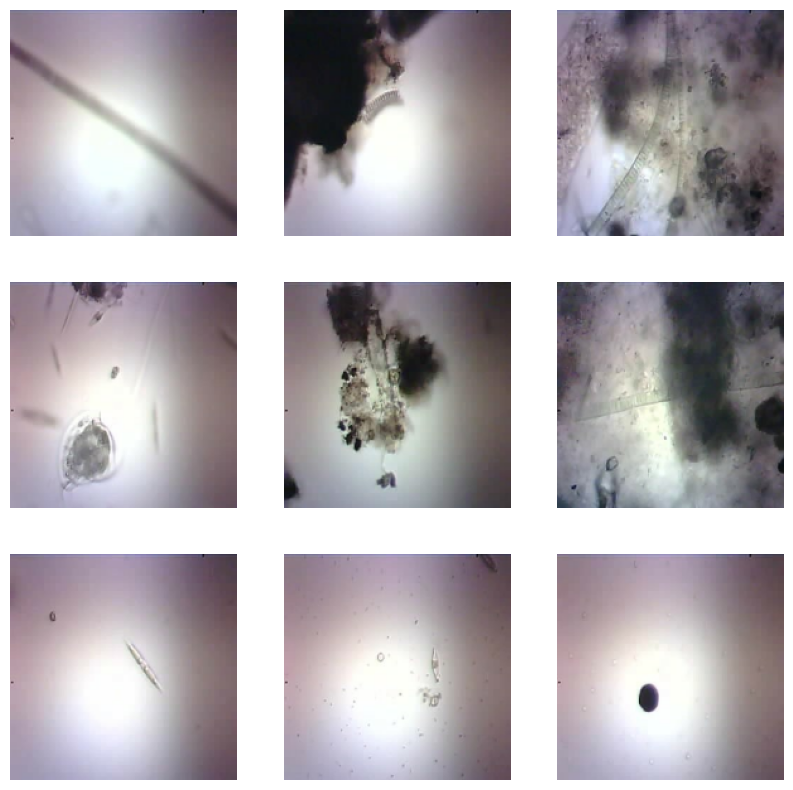

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
# this stuff allows the use of buffered prefetching to load images from disk without i/o blocking

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling

model = Sequential()

model.add(Rescaling(1./255,  input_shape=(img_height, img_width, 3)))

# these layers are from the tutorial
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))

# drop out layer to help with overfitting
model.add(Dropout(0.2))

# 5 classes
model.add(Dense(5, activation='softmax'))

In [9]:
# SparseCategoricalCrossentropy when there are two or more label classes
model.compile(
            optimizer='adam',
            # optimizer='rmsprop',
            # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


55/55 [==============================] - 7s 123ms/step - loss: 1.4298 - accuracy: 0.3840 - val_loss: 1.2858 - val_accuracy: 0.4624
Epoch 2/20
55/55 [==============================] - 6s 118ms/step - loss: 1.3116 - accuracy: 0.4198 - val_loss: 1.1902 - val_accuracy: 0.4852
Epoch 3/20
55/55 [==============================] - 7s 120ms/step - loss: 1.2195 - accuracy: 0.4761 - val_loss: 1.1431 - val_accuracy: 0.5216
Epoch 4/20
55/55 [==============================] - 7s 125ms/step - loss: 1.1129 - accuracy: 0.5279 - val_loss: 1.0949 - val_accuracy: 0.5148
Epoch 5/20
55/55 [==============================] - 6s 118ms/step - loss: 0.9980 - accuracy: 0.6030 - val_loss: 0.9966 - val_accuracy: 0.5718
Epoch 6/20
55/55 [==============================] - 7s 122ms/step - loss: 0.8477 - accuracy: 0.6655 - val_loss: 0.9154 - val_accuracy: 0.6560
Epoch 7/20
55/55 [==============================] - 7s 119ms/step - loss: 0.7013 - accuracy: 0.7275 - val_loss: 0.8526 - val_accuracy: 0.6241
Epoch 8/20
55/55 

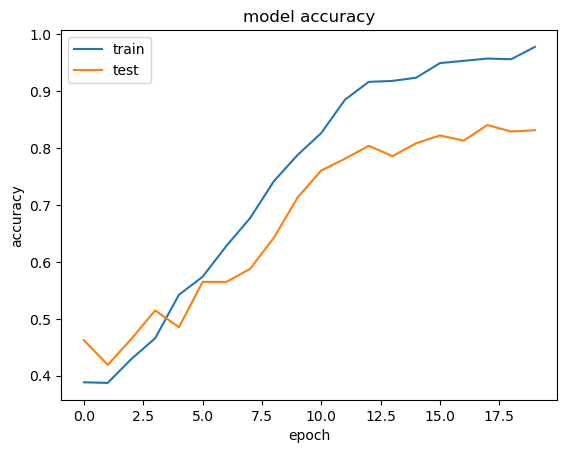

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

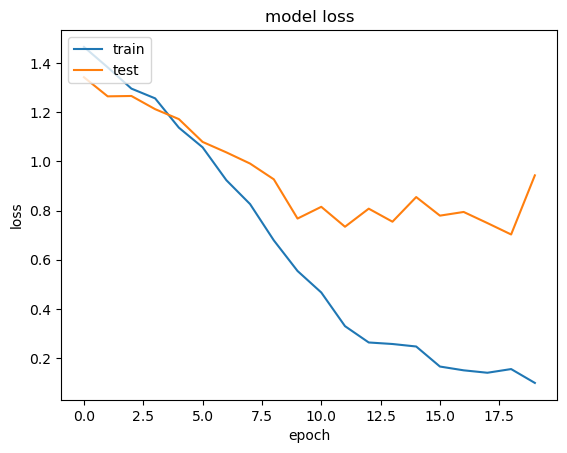

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# save the model to export
model_json = model.to_json()
with open("tf_model.json", "w") as json_file:
    json_file.write(model_json)

# save the weights
model.save_weights("tf_model_weights.h5")